In [1]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
print('Added to PYTHONPATH')

Added to PYTHONPATH


In [2]:
from __future__ import division
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve, GridSearchCV, cross_val_score, ParameterGrid

import composition as comp

%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
sns.set_palette('muted')
sns.set_color_codes()

In [4]:
df, cut_dict = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'StationDensity', 'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(
    df, feature_list, train_he=True, test_he=True)

print('number training events = ' + str(y_train.shape[0]))

/home/jbourbeau/cr-composition/composition/load_sim.py:109: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_1_30'] = np.nan_to_num(np.log10(df['NChannels_1_30']))


training features = ['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith', 'NChannels_1_30', 'log_s125']
number training events = 109652


[CV] classifier__learning_rate=0.2 ...................................
[CV] classifier__learning_rate=0.242105263158 ........................
[CV] classifier__learning_rate=0.284210526316 ........................
[CV] classifier__learning_rate=0.326315789474 ........................
[CV] classifier__learning_rate=0.368421052632 ........................
[CV] classifier__learning_rate=0.410526315789 ........................
[CV] classifier__learning_rate=0.452631578947 ........................
[CV] classifier__learning_rate=0.494736842105 ........................
[CV] classifier__learning_rate=0.536842105263 ........................
[CV] classifier__learning_rate=0.578947368421 ........................
[CV] classifier__learning_rate=0.621052631579 ........................
[CV] classifier__learning_rate=0.663157894737 ........................
[CV] classifier__learning_rate=0.705263157895 ........................
[CV] classifier__learning_rate=0.747368421053 ........................
[CV] c

[Parallel(n_jobs=20)]: Done  67 out of 200 | elapsed:  1.3min remaining:  2.6min


[CV] classifier__learning_rate=0.452631578947 ........................
[CV] classifier__learning_rate=0.494736842105 ........................
[CV]  classifier__learning_rate=0.831578947368, score=0.546599 -   0.2s
[CV] classifier__learning_rate=0.536842105263 ........................
[CV]  classifier__learning_rate=0.578947368421, score=0.540671 -   0.3s
[CV]  classifier__learning_rate=0.494736842105, score=0.542404 -   0.3s
[CV]  classifier__learning_rate=0.747368421053, score=0.544410 -   0.3s
[CV] classifier__learning_rate=0.578947368421 ........................
[CV] classifier__learning_rate=0.621052631579 ........................
[CV] classifier__learning_rate=0.663157894737 ........................
[CV]  classifier__learning_rate=0.621052631579, score=0.539577 -   0.3s
[CV]  classifier__learning_rate=0.663157894737, score=0.542860 -   0.3s
[CV] classifier__learning_rate=0.747368421053 ........................
[CV] classifier__learning_rate=0.705263157895 ........................


[Parallel(n_jobs=20)]: Done 134 out of 200 | elapsed:  2.7min remaining:  1.3min


[CV]  classifier__learning_rate=0.747368421053, score=0.539079 -   0.3s
[CV] classifier__learning_rate=0.789473684211 ........................
[CV]  classifier__learning_rate=0.705263157895, score=0.539444 -   0.4s
[CV] classifier__learning_rate=0.831578947368 ........................
[CV]  classifier__learning_rate=0.242105263158, score=0.546333 -   0.3s
[CV] classifier__learning_rate=0.873684210526 ........................
[CV]  classifier__learning_rate=0.915789473684, score=0.542636 -   0.4s
[CV] classifier__learning_rate=0.915789473684 ........................
[CV]  classifier__learning_rate=0.873684210526, score=0.541359 -   0.3s
[CV] classifier__learning_rate=0.957894736842 ........................
[CV] .......... classifier__learning_rate=0.2, score=0.544783 -   0.4s
[CV] classifier__learning_rate=1.0 ...................................
[CV]  classifier__learning_rate=0.326315789474, score=0.549799 -   0.3s
[CV] classifier__learning_rate=0.2 ...................................


[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:  4.0min finished


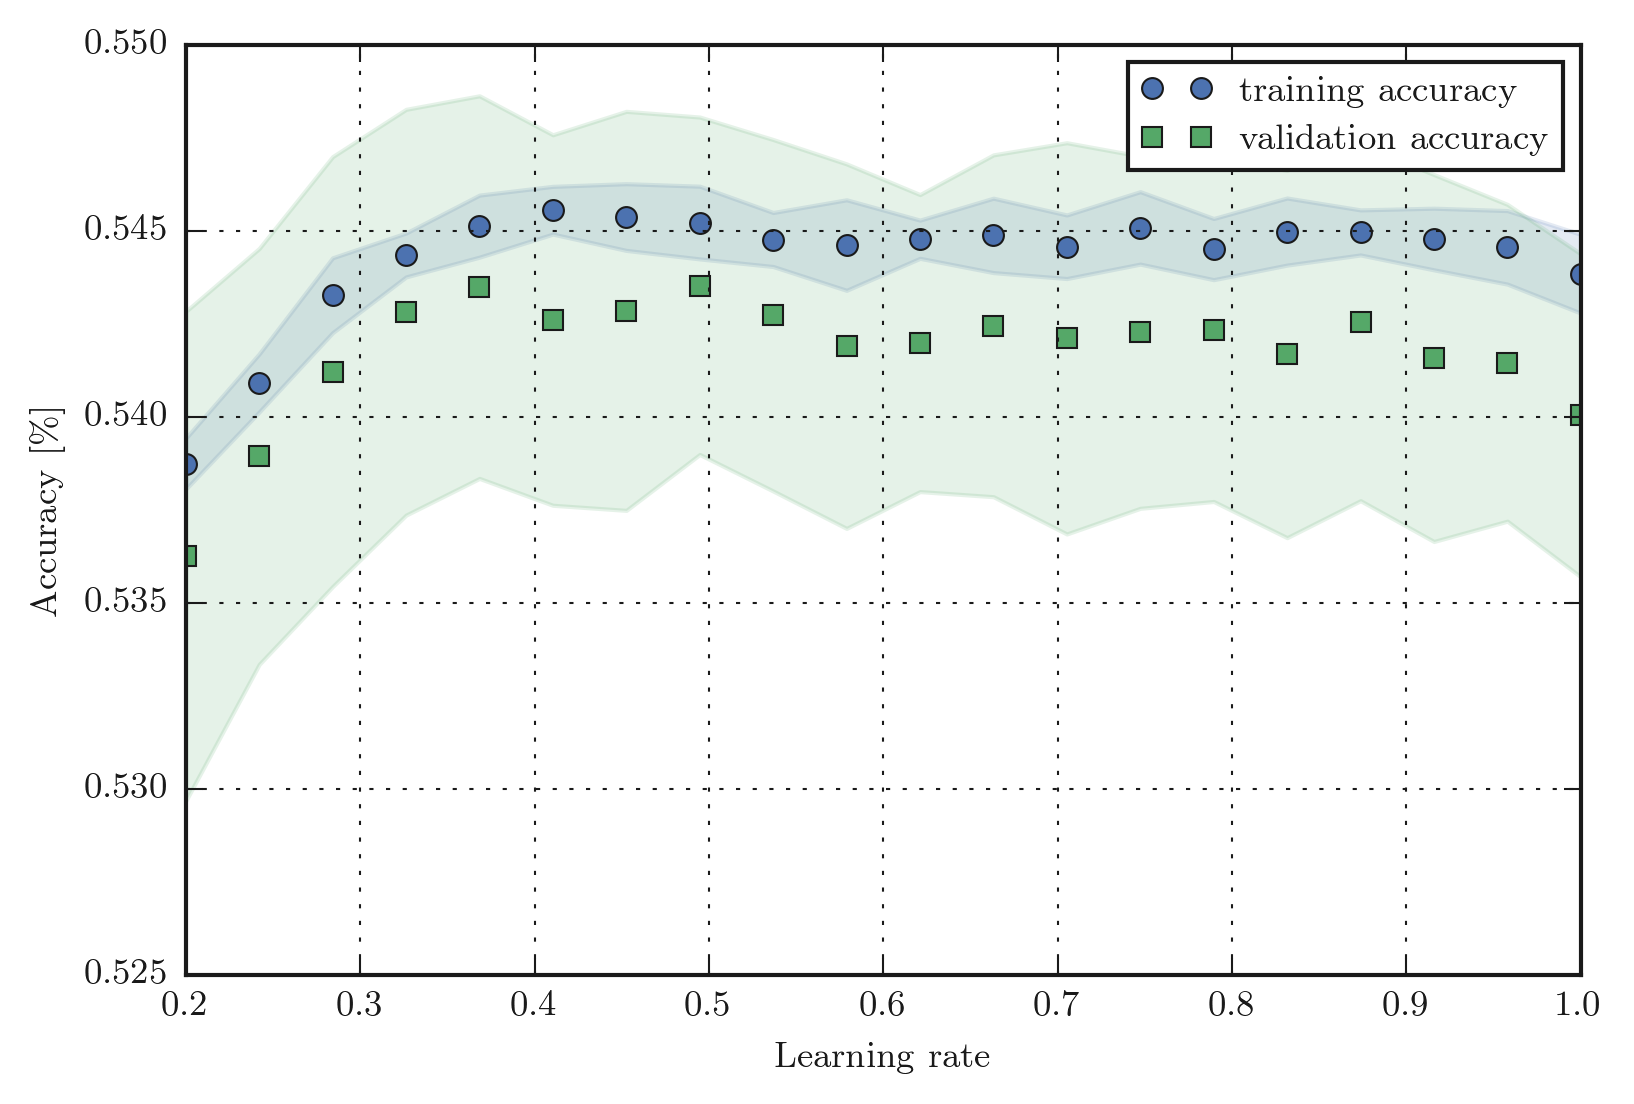

In [5]:
pipeline = comp.get_pipeline('AB')
param_range = np.linspace(0.2, 1.0, 20)
# param_range = np.arange(1, 20)
train_scores, test_scores = validation_curve(
                estimator=pipeline, 
                X=X_train, 
                y=y_train, 
                param_name='classifier__learning_rate', 
#                 param_name='classifier__max_depth', 
                param_range=param_range,
                cv=10,
                verbose=3,
                n_jobs=20)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='b', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='b')

plt.plot(param_range, test_mean, 
         color='g', linestyle='None', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='g')

plt.grid()
# plt.xscale('log')
plt.legend()
# plt.legend(loc='lower right')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy [\%]')
# plt.ylim([0.8, 1.0])
# plt.tight_layout()
plt.savefig('/home/jbourbeau/public_html/figures/composition/parameter-tuning/AdaBoost-validation_curve_learning_rate.png', dpi=300)
# plt.show()

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


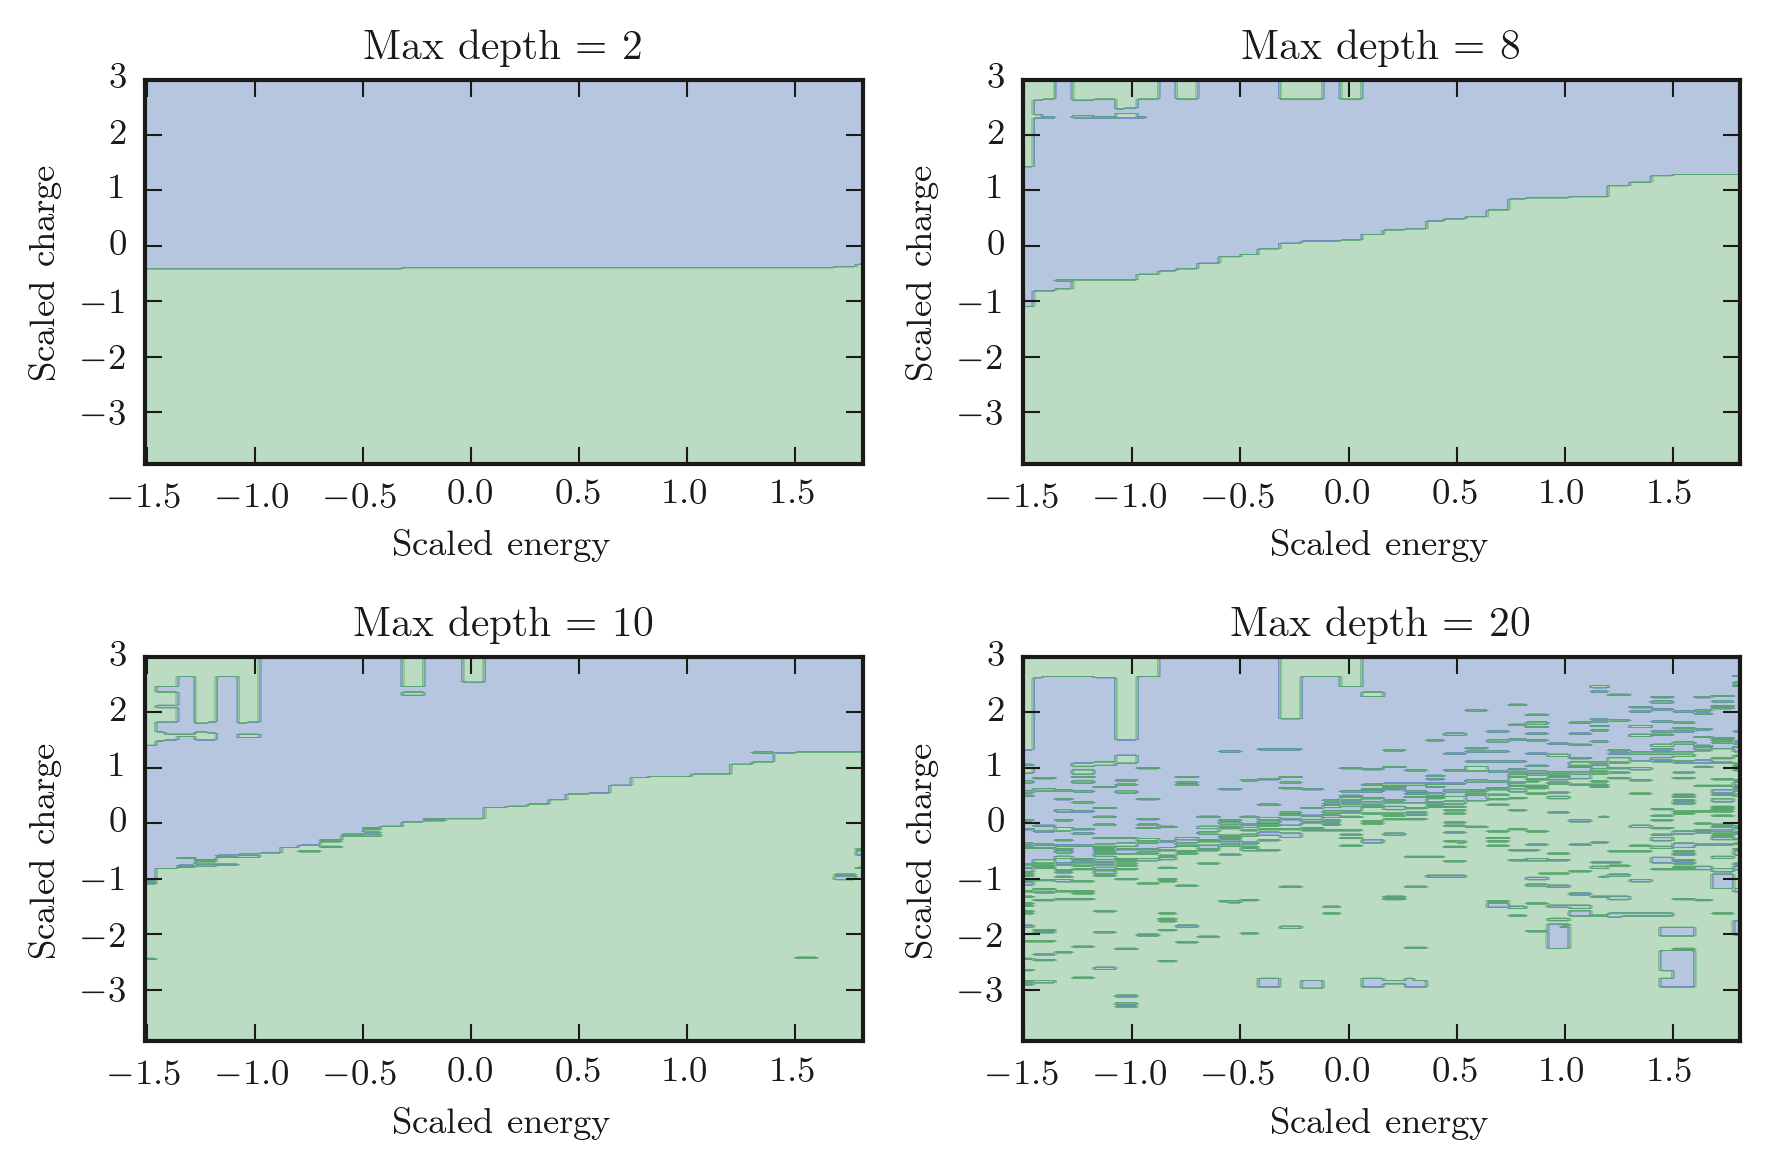

In [4]:
max_depth_list = [2, 8, 10, 20]

fig, axarr = plt.subplots(2,2)
for depth, ax in zip(max_depth_list, axarr.flatten()):
    pipeline = get_pipeline('RF')
    pipeline.named_steps['classifier'].set_params(max_depth=depth)
    pipeline.fit(X_train, y_train)
    scaler = pipeline.named_steps['scaler']
    clf = pipeline.named_steps['classifier']
    X_test_std = scaler.transform(X_test)
    plot_decision_regions(X_test_std, y_test, clf, scatter_fraction=None, ax=ax)
    ax.set_xlabel('Scaled energy')
    ax.set_ylabel('Scaled charge')
    ax.set_title('Max depth = {}'.format(depth))
    ax.legend()
plt.tight_layout()
plt.savefig('/home/jbourbeau/public_html/figures/composition/parameter-tuning/RF-decision-regions.png')


In [5]:
pipeline = get_pipeline('RF')
param_range = np.arange(1, 20)
param_grid = {'classifier__max_depth': param_range}
gs = GridSearchCV(estimator=pipeline, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7872226199
{'classifier__max_depth': 10}
